In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#

<h1> Classification and a hint of "modern methods" </h1>

<h3> In (supervised) classification problems we have a response that is categorical, the most simple setting being Yes/No, True/False, Sick/Healthy or 0/1. You want to find variables that explain the probability of Yes/True/Sick/1. Here we will use data from a company that wants to find out what drives employee attrition, try to fit a good model for prediction and find what are the strongest drivers of attrition.</h3> 

<h3> Data import </h3>

In [ ]:
import matplotlib.pyplot as plt

attr=pd.read_csv('general_data.csv')

<h3> We want to build a model that predicts attrition well. First som initial data checks. </h3>

In [3]:
attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [7]:
#attr.describe()
#attr['Attrition'].value_counts()
#attr['Department'].value_counts()
#attr['EducationField'].value_counts()
#attr['Over18'].value_counts()
#attr['Gender'].value_counts()
#attr['EmployeeCount'].value_counts()
attr['StandardHours'].value_counts()
#attr['BusinessTravel'].value_counts()

StandardHours
8    4410
Name: count, dtype: int64

<h3> Drop variables with no variability. </h3>

In [8]:
attr1=attr.drop(['Over18','EmployeeCount','StandardHours'],axis=1)

<h3> Create dummies to get only numerical variables as model inputs </h3>

In [9]:
#Creating dummies
cat_vars=['Attrition','Department','JobRole','MaritalStatus','EducationField','Gender','BusinessTravel']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(attr1[var], prefix=var)
    attr2=attr1.join(cat_list)
    attr1=attr2
    
cat_vars=['Attrition','Department','JobRole','MaritalStatus','EducationField','Gender','BusinessTravel']
data_vars=attr1.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

<h3> Remove categorical variables from dataset. </h3>

In [11]:
attr4=attr1[to_keep]
#print(attr4)
attr4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4410 non-null   int64  
 1   DistanceFromHome                   4410 non-null   int64  
 2   Education                          4410 non-null   int64  
 3   EmployeeID                         4410 non-null   int64  
 4   JobLevel                           4410 non-null   int64  
 5   MonthlyIncome                      4410 non-null   int64  
 6   NumCompaniesWorked                 4391 non-null   float64
 7   PercentSalaryHike                  4410 non-null   int64  
 8   StockOptionLevel                   4410 non-null   int64  
 9   TotalWorkingYears                  4401 non-null   float64
 10  TrainingTimesLastYear              4410 non-null   int64  
 11  YearsAtCompany                     4410 non-null   int64

<h3> Create model input data: Impute means for missing values, standardize X-data and split to training and test data. </h3>

In [12]:
attr5=attr4.columns.values.tolist()
y=attr4['Attrition_Yes']
X=attr4.drop(['Attrition_Yes','Attrition_No','EmployeeID'],axis=1)
#X=attr4.drop(['Attrition_Yes','Attrition_No','EmployeeID','JobRole_Healthcare Representative','MaritalStatus_Single','EducationField_Human Resources','Gender_Female','BusinessTravel_Non-Travel'],axis=1)

from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)
X_imp=imp.transform(X)

from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X_imp)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_std, y,
                                                   test_size=0.33,
                                                   random_state=0,
                                                   stratify=y)

<h3> Fit logistic regression with elastic net using cross-validation to find hyperparameters. </h3>
<h3>A logistic regression means that if $p_{attrition}$ is the probability of attrition, we fit a model according to</h3>
<h3>$\log\left(\frac{p_{attrition}}{1-p_{attrition}}\right)=\beta_0+\beta_1 x_1+\dots+\beta_k x_k+\epsilon$</h3>
<h3>The tranformation $x \mapsto \log\left(\frac{x}{1-x}\right)$ is called logit and maps a variable that takes values on $(0,1)$ to $(-\infty,\infty)$</h3>
<h3>We use a technique called elastic net to shrink parameter estimates of less important variables.</h3>

In [13]:

from sklearn.linear_model import LogisticRegressionCV
model =LogisticRegressionCV(Cs=np.linspace(0.001,0.01,100), fit_intercept=True, cv=5, dual=False, 
                   intercept_scaling=1, l1_ratios=np.linspace(0.001,0.001,1), refit=True, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='elasticnet',
                   random_state=0, solver='saga', tol=0.0001, verbose=0).fit(x_train, y_train)

<h3> How well does the model perform in-sample? To analyze this we use a ROC-curve, where we want the area under the curve to be as close to 1 as possible. </h3>

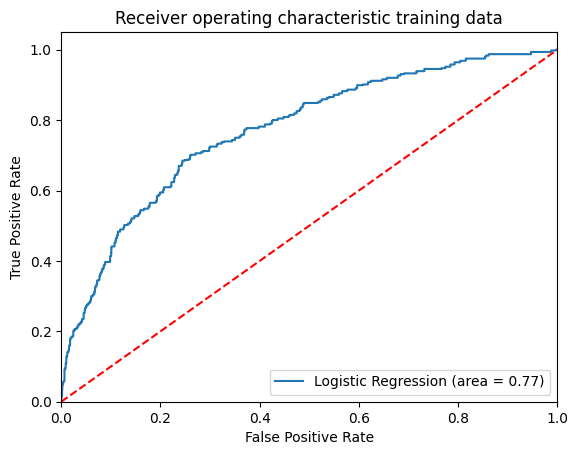

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc_train = roc_auc_score(y_train, model.predict_proba(x_train)[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, model.predict_proba(x_train)[:,1])
plt.figure()
plt.plot(fpr_train, tpr_train, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic training data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


<h3> An AUC of 77% is not so bad, but how well does the model predict out-of-sample? </h3>

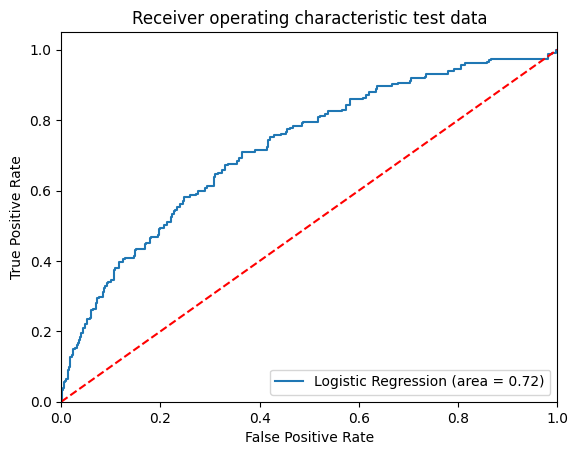

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc_test = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, model.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic test data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

<h3> Clearly, the model performs worse out-of-sample (test data) than in-sample (training data). This might be an indication that the model is "overfit", meaning that it to some extent captures the noise in the training data. Can we fit a better model? Maybe a Random Forest? What is a Random Forest? </h3>

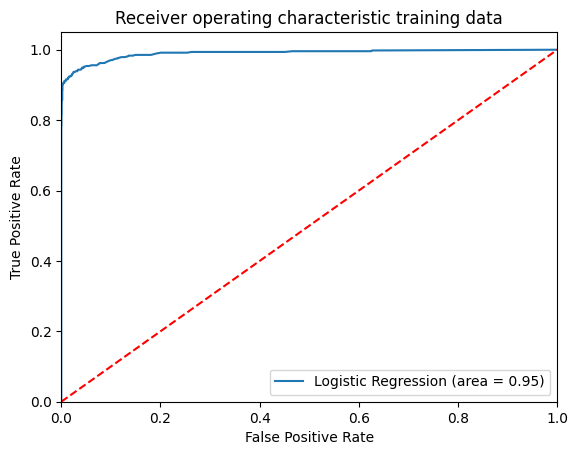

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
modelRF = RandomForestClassifier(n_estimators=100, 
                               random_state=2,
                            oob_score=True,
                                 bootstrap=True,
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0).fit(x_train, y_train)


# Fit on training data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
RF_roc_auc_train = roc_auc_score(y_train, np.argmax(modelRF.oob_decision_function_,axis=1))
fpr_train_RF, tpr_train_RF, thresholds_train_RF = roc_curve(y_train, modelRF.oob_decision_function_[:,1])
plt.figure()
plt.plot(fpr_train_RF, tpr_train_RF, label='Logistic Regression (area = %0.2f)' % RF_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic training data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

<h3> Is the out-of-sample performance better for the RF than for the Logit model? </h3>

In [17]:
train_predictions = modelRF.predict(x_train)
train_probs = modelRF.predict_proba(x_train)[:, 1]

predictions = modelRF.predict(x_test)
probs = modelRF.predict_proba(x_test)[:, 1]

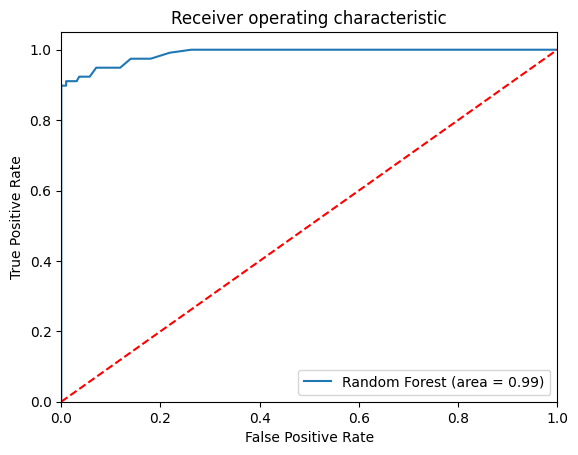

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, modelRF.predict_proba(x_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, modelRF.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

<h3> Obviously, the performance is much better using the RF than the Logit. Which variable is most important in the RF? </h3>

In [19]:
df_x_test=pd.DataFrame(x_test)
from sklearn.inspection import permutation_importance
result = permutation_importance(modelRF, df_x_test, y_test,
                            n_repeats=30,
                            random_state=0)

<h3> In order to find out the names of the most important variables, we join the actual variable names to the generic names created when standardizing </h3>

In [20]:
df=pd.concat([pd.DataFrame({'Variable': pd.DataFrame(X).columns.tolist()}),pd.DataFrame({'Importance':result.importances_mean})],axis=1)
df1=df.sort_values(by='Importance',ascending=False)
df1.head(10)

,Variable,Importance
0,Age,0.044780
27,MaritalStatus_Single,0.037523
10,YearsAtCompany,0.021131
5,NumCompaniesWorked,0.019483
12,YearsWithCurrManager,0.019025
11,YearsSinceLastPromotion,0.016003
4,MonthlyIncome,0.014217
8,TotalWorkingYears,0.013645
6,PercentSalaryHike,0.013347
37,BusinessTravel_Travel_Frequently,0.011722


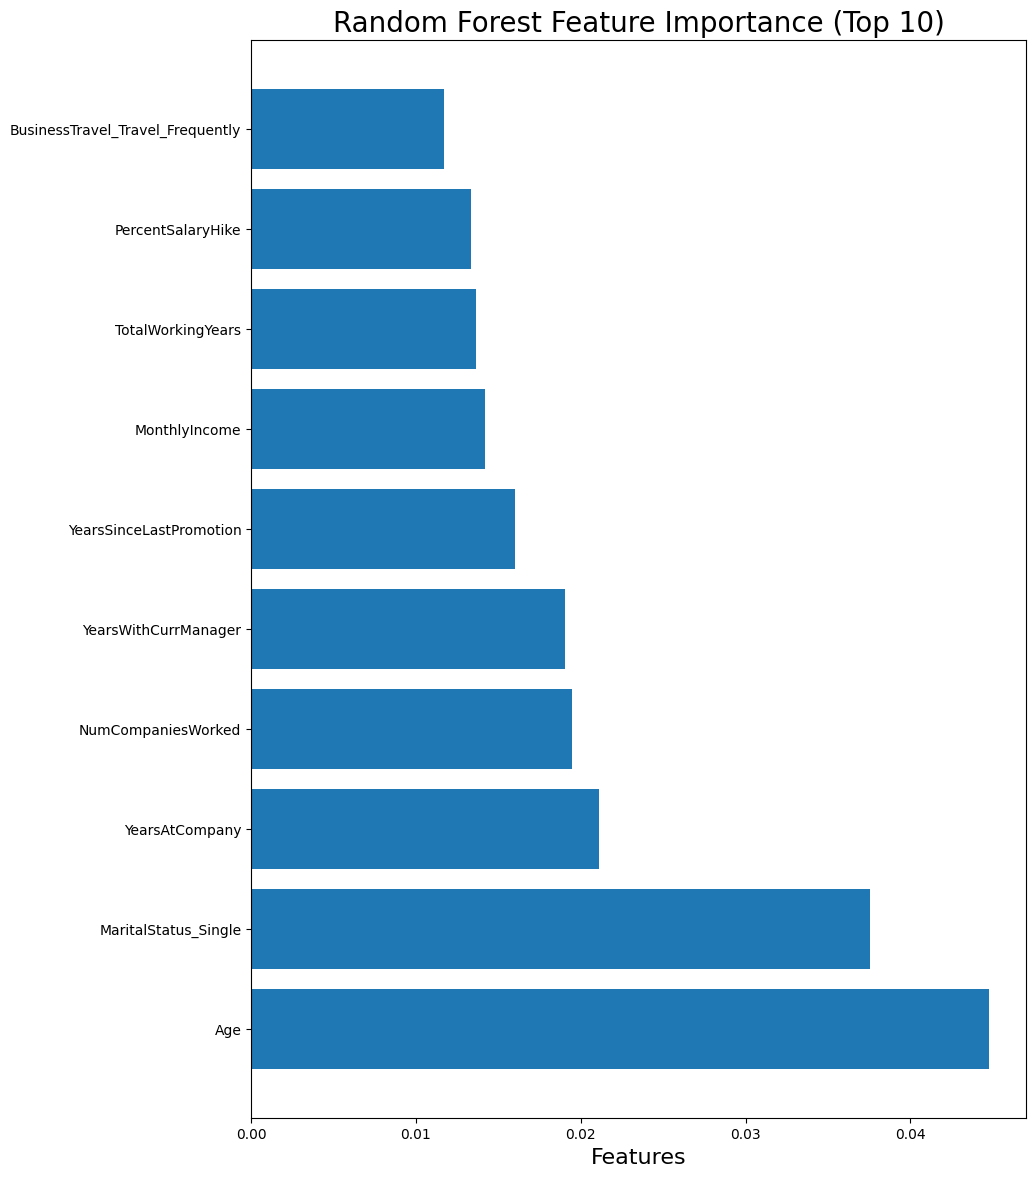

In [22]:
feature_names_10 = [i for i in df1['Variable'][:10]]
y_ticks = np.arange(0, len(feature_names_10))
x_axis = [i for i in df1['Importance'][:10]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_10, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 10)',
          fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

<h1>The CLT Bonus</h1>

In [ ]:
#Importing standard libraries 
import numpy as np #used for random number generator
from scipy.stats import norm #extension of numpy for stat analysis
from scipy.stats import gamma #extension of numpy for stat analysis
import pandas as pd #used for data manipulation
import matplotlib.pyplot as plt #used for quick plotting
import seaborn as sns #used to plot distributions
import warnings #used to ignore displot warning
warnings.filterwarnings('ignore')

In [ ]:
#Define an array for 20,000 samples per each sample size 
samples_2 = np.zeros(20000) 
samples_5 = np.zeros(20000) 
samples_10 = np.zeros(20000) 
samples_100 = np.zeros(20000) 
samples_250 = np.zeros(20000)
#Defining parameters from our population distribution
mu, sigma = 15, 2

In [ ]:
#Defining parameters from our population distribution
mu, sigma = 15, 2
#Creating for loop for sample size 2
for x in range(20000):
    sample = np.random.normal(mu, sigma, 2)
    x_bar_2 = sample.mean()
    samples_2[x] = np.sqrt(2)*(x_bar_2-15)/2
#Creating for loop for sample size 5
for a in range(20000):
    sample = np.random.normal(mu, sigma, 5)
    x_bar_5 = sample.mean()
    samples_5[a] = np.sqrt(5)*(x_bar_5-15)/2
#Creating for loop for sample size 10
for b in range(20000):
    sample = np.random.normal(mu, sigma, 10)
    x_bar_10 = sample.mean()
    samples_10[b] = np.sqrt(10)*(x_bar_10-15)/2
#Creating for loop for sample size 100
for c in range(20000):
    sample = np.random.normal(mu, sigma, 100)
    x_bar_100 = sample.mean()
    samples_100[c] = np.sqrt(100)*(x_bar_100-15)/2
#Creating for loop for sample size 250
for d in range(20000):
    sample = np.random.normal(mu, sigma, 250)
    x_bar_250 = sample.mean()
    samples_250[d] = np.sqrt(250)*(x_bar_250-15)/2

In [ ]:
#Combining arrays into a dataframe to plot
df = pd.DataFrame(np.vstack((samples_2,samples_5,samples_10,
                             samples_100,samples_250)))
df = df.T
df.columns = ['2','5','10','100','250']
#Plotting Distributions
plt.figure(figsize=(20,10))
sns.distplot(df['2'])
#sns.distplot(df['5'])
#sns.distplot(df['10'])
#sns.distplot(df['100'])
#sns.distplot(df['250'])
plt.title('Normal Dist', fontsize=20)
plt.xlabel('Standardized Sample Mean', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(df, fontsize=20)
plt.show()

In [ ]:
#Define an array for 20,000 samples per each sample size
samples_2 = np.zeros(20000) 
samples_5 = np.zeros(20000) 
samples_10 = np.zeros(20000) 
samples_100 = np.zeros(20000) 
samples_250 = np.zeros(20000)
#Defining parameters from our population distribution

In [ ]:
#Defining parameters from our population distribution
beta = 1
#Creating for loop for sample size 2
for x in range(20000):
    sample = np.random.exponential(beta, 2)
    x_bar_2 = sample.mean()
    samples_2[x] = np.sqrt(2)*(x_bar_2-1)
    #Creating for loop for sample size 5
for a in range(20000):
    sample = np.random.exponential(beta, 5)
    x_bar_5 = sample.mean()
    samples_5[a] = np.sqrt(5)*(x_bar_5-1)
#Creating for loop for sample size 10
for b in range(20000):
    sample = np.random.exponential(beta, 10)
    x_bar_10 = sample.mean()
    samples_10[b] = np.sqrt(10)*(x_bar_10-1)
#Creating for loop for sample size 100
for c in range(20000):
    sample = np.random.exponential(beta, 100)
    x_bar_100 = sample.mean()
    samples_100[c] = np.sqrt(100)*(x_bar_100-1)
#Creating for loop for sample size 250
for d in range(20000):
    sample = np.random.exponential(beta, 250)
    x_bar_250 = sample.mean()
    samples_250[d] = np.sqrt(250)*(x_bar_250-1)

In [ ]:
#Combining arrays into a dataframe to plot
df = pd.DataFrame(np.vstack((samples_2,samples_5,samples_10,
                             samples_100,samples_250)))
df = df.T
df.columns = ['2','5','10','100','250']
#Plotting Distributions
plt.figure(figsize=(20,10))
#sns.distplot(df['2'])
#sns.distplot(df['5'])
#sns.distplot(df['10'])
sns.distplot(df['100'])
#sns.distplot(df['250'])
plt.title('CLT for exponential distribution', fontsize=20)
plt.xlabel('Standardized Sample Mean', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(df, fontsize=20)
plt.show()

In [ ]:
#Define an array for 20,000 samples per each sample size
samples_2 = np.zeros(20000) 
samples_5 = np.zeros(20000) 
samples_10 = np.zeros(20000) 
samples_100 = np.zeros(20000) 
samples_250 = np.zeros(20000)
#Defining parameters from our population distribution

In [ ]:
#Defining parameters from our population distribution
lo, hi = 0,2
#Creating for loop for sample size 2
for x in range(20000):
    sample = np.random.uniform(lo, hi, 2)
    x_bar_2 = sample.mean()
    samples_2[x] = np.sqrt(2*3)*(x_bar_2-1)
    #Creating for loop for sample size 5
for a in range(20000):
    sample = np.random.uniform(lo, hi, 5)
    x_bar_5 = sample.mean()
    samples_5[a] = np.sqrt(5*3)*(x_bar_5-1)
#Creating for loop for sample size 10
for b in range(20000):
    sample = np.random.uniform(lo, hi, 10)
    x_bar_10 = sample.mean()
    samples_10[b] = np.sqrt(10*3)*(x_bar_10-1)
#Creating for loop for sample size 100
for c in range(20000):
    sample = np.random.uniform(lo, hi, 100)
    x_bar_100 = sample.mean()
    samples_100[c] = np.sqrt(100*3)*(x_bar_100-1)
#Creating for loop for sample size 250
for d in range(20000):
    sample = np.random.uniform(lo, hi, 250)
    x_bar_250 = sample.mean()
    samples_250[d] = np.sqrt(250*3)*(x_bar_250-1)

In [ ]:
#Combining arrays into a dataframe to plot
df = pd.DataFrame(np.vstack((samples_2,samples_5,samples_10,
                             samples_100,samples_250)))
df = df.T
df.columns = ['2','5','10','100','250']
#Plotting Distributions
plt.figure(figsize=(20,10))
#sns.distplot(df['2'])
#sns.distplot(df['5'])
sns.distplot(df['10'])
#sns.distplot(df['100'])
#sns.distplot(df['250'])
plt.title('CLT for uniform distribution', fontsize=20)
plt.xlabel('Standardized Sample Mean', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(df, fontsize=20)
plt.show()